# GlickoTR (Tennis Rating) Simulation Test

This notebook simulates multiple players and matches to observe the behavior of the modified Glicko-2 algorithm (`glickoTR.py`) which incorporates game scores and match completeness.

In [44]:
# Imports
import random
import matplotlib.pyplot as plt
import numpy as np
import math

# Import the modified Glicko-2 Tennis Refined algorithm
# Make sure glickoTR.py is in the same directory or Python path
try:
    from glickoTR import Glicko2, Rating, COMPLETED, RETIRED, WALKOVER
except ImportError:
    print("Error: Could not import from glickoTR.py.")
    print("Make sure glickoTR.py is in the same directory or accessible in your PYTHONPATH.")
    # Provide default values so the rest of the notebook doesn't immediately crash
    COMPLETED, RETIRED, WALKOVER = 'completed', 'retired', 'walkover'
    class Rating: pass
    class Glicko2: pass # Dummy class


## 1. Generate Players

Create 100 players with default initial ratings using the Glicko2 environment.

In [45]:
# Initialize Glicko-2 environment
# Tau controls how much volatility changes. Smaller tau = slower changes.
env = Glicko2() # Using the imported Glicko2 class from glickoTR

NUM_PLAYERS = 1000

# Store current ratings (dictionary: player_id -> Rating object)
players = {}
# Store rating history (dictionary: player_id -> list of Rating objects)
rating_history = {}

if isinstance(env, Glicko2) and hasattr(env, 'create_rating'): # Check if import succeeded
    for i in range(NUM_PLAYERS):
        initial_rating = env.create_rating() # Uses defaults: mu=1500, phi=350, sigma=0.06
        players[i] = initial_rating
        rating_history[i] = [initial_rating] # Start history with the initial rating

    print(f"Generated {len(players)} players.")
    if 0 in players:
         print(f"Example Player 0: {players[0]}")
    else:
         print("Player dictionary is empty.")
else:
    print("Skipping player generation due to import error.")


Generated 1000 players.
Example Player 0: glickoTR.Rating(mu=1500.000, phi=350.000, sigma=0.060)


## 2. Generate Random Matches

Generate random pairings between players.

In [46]:
NUM_MATCHES = 10000
matches_to_simulate = []

if players: # Only generate matches if players were created
    player_ids = list(players.keys())
    if len(player_ids) >= 2:
        for _ in range(NUM_MATCHES):
            # Select two distinct players randomly
            p1_id, p2_id = random.sample(player_ids, 2)
            matches_to_simulate.append((p1_id, p2_id))

        print(f"Generated {len(matches_to_simulate)} match pairings.")
        print("First 5 match pairings (player IDs):")
        print(matches_to_simulate[:5])
    else:
        print("Not enough players to generate matches.")
else:
     print("Skipping match generation as players were not created.")


Generated 10000 match pairings.
First 5 match pairings (player IDs):
[(869, 443), (513, 455), (899, 842), (424, 960), (924, 745)]


## 3. Calculate and Update Ratings After Each Match

Simulate each match using the `glickoTR` logic:
- Determine winner probabilistically based on `expected_score`.
- Randomly assign match status (COMPLETED/RETIRED).
- Generate plausible game scores based on winner and status.
- Update ratings using `rate_tennis_match`.

In [47]:
def simulate_game_scores(p1_wins, status):
    """Generates plausible game scores based on winner and status."""
    if status == COMPLETED:
        # Typical completed Bo3 matches range from 12 games (6-0, 6-0) to ~38 (7-6, 6-7, 7-5)
        # Let's simulate a slightly tighter range for simplicity
        total_games = random.randint(12, 30)
    elif status == RETIRED:
        # Retired matches can have fewer games, e.g., 1 to 17 (up to finishing 2 sets partially)
        total_games = random.randint(1, 17)
    else: # Should not happen if we only simulate COMPLETED/RETIRED
        return 0, 0

    # Distribute games, ensuring winner gets > 50%
    # This is a simplification; real scorelines are more complex.
    if p1_wins:
        # Winner gets between 51% and 95% of games (adjust range as needed)
        # Ensure win_share > 0.5 even with rounding
        win_share = random.uniform(0.501, 0.95)
        games1 = math.ceil(total_games * win_share)
        games2 = total_games - games1
        # Ensure winner has strictly more games if total_games is even
        if games1 <= games2: games1 = games2 + 1
        games2 = total_games - games1 # Recalculate games2 based on adjusted games1
    else: # p2 wins
        win_share = random.uniform(0.501, 0.95)
        games2 = math.ceil(total_games * win_share)
        games1 = total_games - games2
        if games2 <= games1: games2 = games1 + 1
        games1 = total_games - games2 # Recalculate games1 based on adjusted games2

    # Ensure non-negative scores and that total games match initial target
    games1 = max(0, games1)
    games2 = max(0, games2)
    # It's possible the adjustments above slightly change total_games, accept this small variance.

    return games1, games2

# --- Simulation Loop ---

match_details_log = [] # Optional: log details for inspection
expected1_log_fallback = 0.5 # Initialize fallback expected1 outside loop

if isinstance(env, Glicko2) and hasattr(env, 'rate_tennis_match') and matches_to_simulate: # Check imports/setup
    print("Starting match simulation...")
    for i, (p1_id, p2_id) in enumerate(matches_to_simulate):
        # Get current ratings
        rating1 = players[p1_id]
        rating2 = players[p2_id]

        # --- Determine winner based on rating difference ---
        mu1 = rating1.mu
        mu2 = rating2.mu
        mu_diff = mu1 - mu2

        rating_diff_threshold = 350.0
        expected1 = expected1_log_fallback # Use fallback by default

        if mu_diff > rating_diff_threshold:
            p1_wins = True # P1 guaranteed win
            # Optional: Estimate expected1 even when deterministic for logging?
            # Could calculate it here, but set it to 1.0 conceptually?
            expected1 = 1.0 # Conceptually, win is guaranteed
        elif mu_diff < -rating_diff_threshold:
            p1_wins = False # P2 guaranteed win (P1 guaranteed loss)
            expected1 = 0.0 # Conceptually, loss is guaranteed
        else:
            # Within the threshold, use probabilistic outcome based on expected score
            try:
                r1_g2 = env.scale_down(rating1)
                r2_g2 = env.scale_down(rating2)
                impact_for_p1 = env.reduce_impact(r2_g2) # Use opponent's RD for impact
                expected1 = env.expect_score(r1_g2, r2_g2, impact_for_p1)
                p1_wins = random.random() < expected1
            except Exception as e:
                # Fallback if calculation fails within threshold
                print(f"Error calculating expected score for match {i+1} (P{p1_id} vs P{p2_id}): {e}. Using 50/50 chance.")
                expected1 = 0.5 # Store fallback expected1
                p1_wins = random.random() < 0.5

        # Store the expected1 value used for logging, handle cases where it might not be calculated
        expected1_log = expected1

        # 3. Determine match status (e.g., 90% completed, 10% retired)
        status = random.choices([COMPLETED, RETIRED], weights=[0.90, 0.10], k=1)[0]

        # 4. Simulate plausible game scores based on winner and status
        games1, games2 = simulate_game_scores(p1_wins, status)

        # --- Update Ratings ---
        try:
            new_rating1, new_rating2 = env.rate_tennis_match(rating1, rating2, games1, games2, status)
        except Exception as e:
            print(f"Error updating ratings for match {i+1} (P{p1_id} vs P{p2_id}): {e}")
            # Keep old ratings if update fails
            new_rating1, new_rating2 = rating1, rating2


        # Update player ratings in our main dictionary
        players[p1_id] = new_rating1
        players[p2_id] = new_rating2

        # Append to history for players involved in this match
        rating_history[p1_id].append(new_rating1)
        rating_history[p2_id].append(new_rating2)

        # Log details (optional)
        match_details_log.append({
            'match_num': i + 1,
            'p1_id': p1_id, 'p2_id': p2_id,
            'p1_mu_before': rating1.mu, 'p2_mu_before': rating2.mu,
            'expected1': expected1_log, # Log the value used or fallback
            'p1_wins_actual': p1_wins,
            'status': status,
            'games1': games1, 'games2': games2,
            'p1_mu_after': new_rating1.mu, 'p2_mu_after': new_rating2.mu
        })

        # Optional: Print progress
        if (i + 1) % 200 == 0:
             print(f"Processed {i+1}/{len(matches_to_simulate)} matches...")

    print("Finished processing all matches.")
    if 0 in players: print(f"Example Player 0 (End): {players[0]}")
    if 1 in players: print(f"Example Player 1 (End): {players[1]}")

    # Example Log entry
    if match_details_log:
        print("\nExample match log entry:")
        import pprint
        # Find a log entry where expected1 was likely calculated (not 0 or 1)
        example_log = next((log for log in match_details_log if 0.01 < log['expected1'] < 0.99), match_details_log[0])
        pprint.pprint(example_log)
else:
    print("Skipping simulation loop due to import errors or lack of matches.")

Starting match simulation...
Processed 200/10000 matches...
Processed 400/10000 matches...
Processed 600/10000 matches...
Processed 800/10000 matches...
Processed 1000/10000 matches...
Processed 1200/10000 matches...
Processed 1400/10000 matches...
Processed 1600/10000 matches...
Processed 1800/10000 matches...
Processed 2000/10000 matches...
Processed 2200/10000 matches...
Processed 2400/10000 matches...
Processed 2600/10000 matches...
Processed 2800/10000 matches...
Processed 3000/10000 matches...
Processed 3200/10000 matches...
Processed 3400/10000 matches...
Processed 3600/10000 matches...
Processed 3800/10000 matches...
Processed 4000/10000 matches...
Processed 4200/10000 matches...
Processed 4400/10000 matches...
Processed 4600/10000 matches...
Processed 4800/10000 matches...
Processed 5000/10000 matches...
Processed 5200/10000 matches...
Processed 5400/10000 matches...
Processed 5600/10000 matches...
Processed 5800/10000 matches...
Processed 6000/10000 matches...
Processed 6200/

## 4. Plot Rating Distribution

Show the distribution of final ratings (mu) across all players.

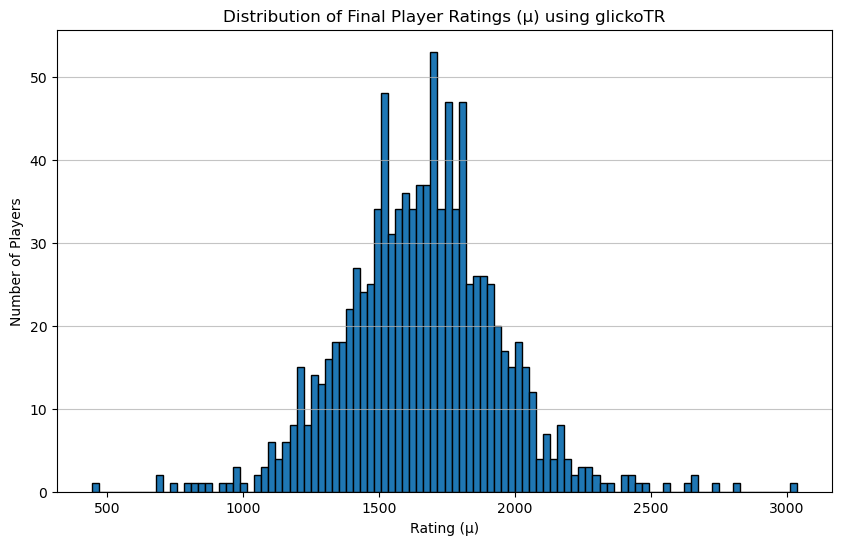

In [48]:
if players: # Check if player data exists
    final_mus = [p.mu for p in players.values() if hasattr(p, 'mu')]

    if final_mus:
        plt.figure(figsize=(10, 6))
        plt.hist(final_mus, bins=100, edgecolor='black')
        plt.title('Distribution of Final Player Ratings (μ) using glickoTR')
        plt.xlabel('Rating (μ)')
        plt.ylabel('Number of Players')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No final ratings data to plot.")
else:
    print("Skipping distribution plot as player data is missing.")


## 5. Plot Specific Player Rating Trend

Show how the rating (mu), RD (phi), and volatility (sigma) of a single player changed over time.

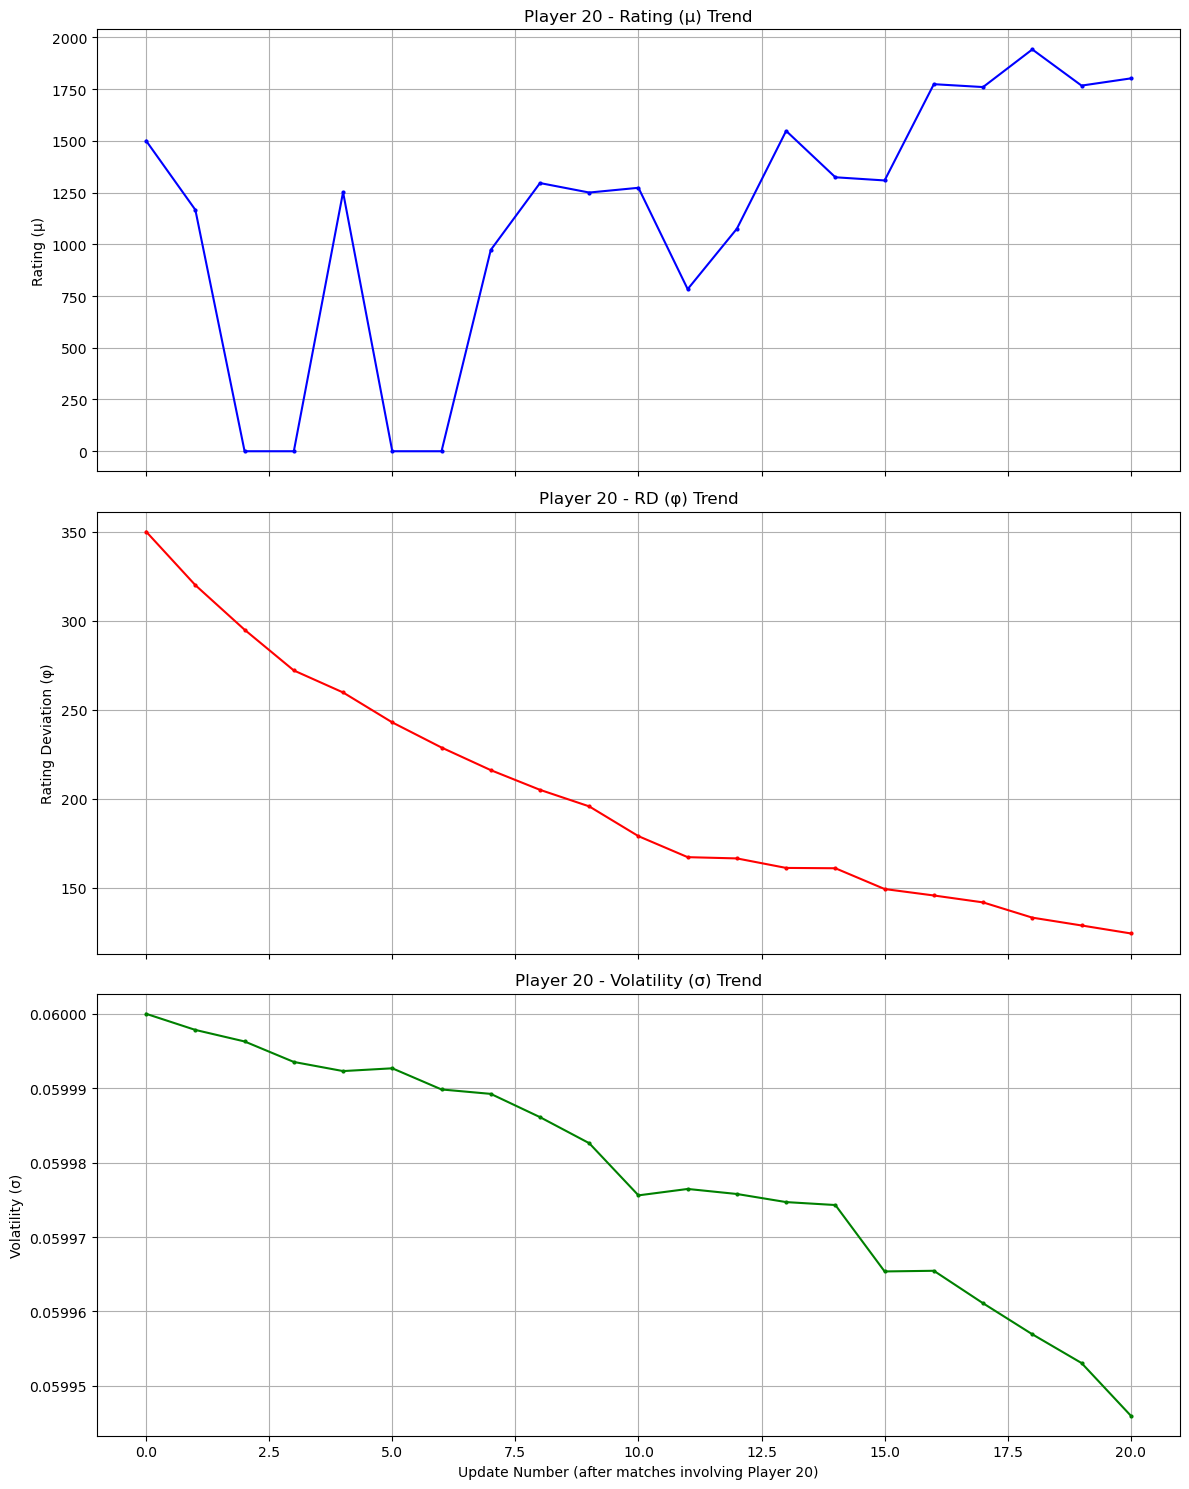

In [49]:
# Choose a player to track (e.g., player 0)
player_id_to_track = 20

if player_id_to_track in rating_history:
    player_hist = rating_history[player_id_to_track]
    # Filter out potential None or non-Rating objects if errors occurred
    player_hist = [r for r in player_hist if hasattr(r, 'mu') and hasattr(r, 'phi') and hasattr(r, 'sigma')]

    if len(player_hist) > 1: # Need at least initial and one update
        mu_history = [r.mu for r in player_hist]
        phi_history = [r.phi for r in player_hist]
        sigma_history = [r.sigma for r in player_hist]
        # Create an index representing the state after each update involving this player
        updates_indices = range(len(mu_history))

        fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

        axs[0].plot(updates_indices, mu_history, marker='.', linestyle='-', markersize=4, color='blue')
        axs[0].set_title(f'Player {player_id_to_track} - Rating (μ) Trend')
        axs[0].set_ylabel('Rating (μ)')
        axs[0].grid(True)

        axs[1].plot(updates_indices, phi_history, marker='.', linestyle='-', markersize=4, color='red')
        axs[1].set_title(f'Player {player_id_to_track} - RD (φ) Trend')
        axs[1].set_ylabel('Rating Deviation (φ)')
        axs[1].grid(True)

        axs[2].plot(updates_indices, sigma_history, marker='.', linestyle='-', markersize=4, color='green')
        axs[2].set_title(f'Player {player_id_to_track} - Volatility (σ) Trend')
        axs[2].set_ylabel('Volatility (σ)')
        axs[2].set_xlabel(f'Update Number (after matches involving Player {player_id_to_track})')
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough valid history data for Player {player_id_to_track} to plot trend.")
else:
    print(f"Player {player_id_to_track} not found in history or history is missing.")


## 6. Q-Q Plot vs. Normal Distribution

Visualize how the final rating distribution compares to a theoretical normal distribution using a Quantile-Quantile plot. Points falling close to the diagonal line suggest normality.

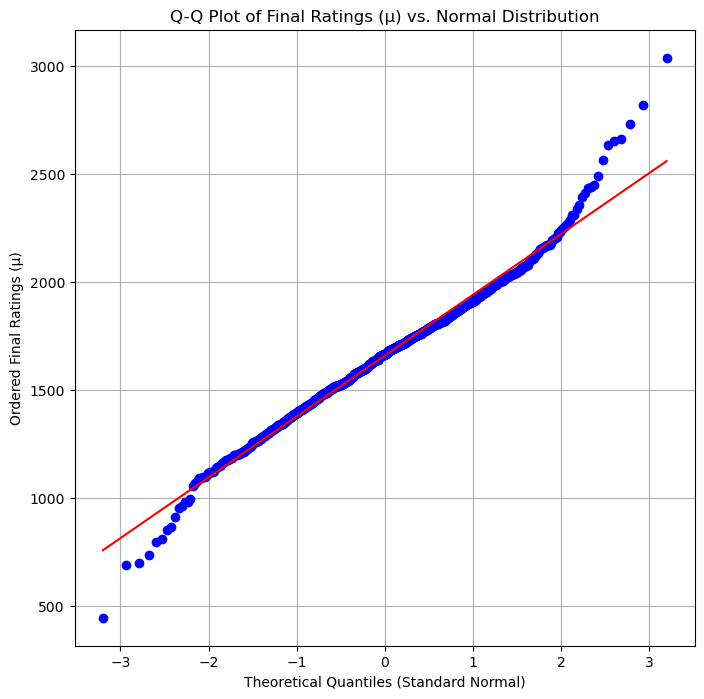

In [50]:
import scipy.stats as stats

if players and 'final_mus' in locals() and final_mus: # Check if data exists
    plt.figure(figsize=(8, 8))
    # Create the Q-Q plot against a normal distribution
    stats.probplot(final_mus, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Final Ratings (μ) vs. Normal Distribution')
    plt.xlabel('Theoretical Quantiles (Standard Normal)')
    plt.ylabel('Ordered Final Ratings (μ)')
    plt.grid(True)
    plt.show()
else:
    print("Skipping Q-Q plot as final ratings data is missing or empty.")


In [51]:
# --- Store Initial Ratings for Update Step ---
initial_players = players.copy() # Keep a copy of the initial ratings

# --- Simulation Loop - Store Results Only ---
all_match_results = []

if isinstance(env, Glicko2) and hasattr(env, 'rate_tennis_match') and matches_to_simulate:
    print("Starting match simulation (storing results)...")
    for i, (p1_id, p2_id) in enumerate(matches_to_simulate):
        # Get INITIAL ratings for simulation logic (winner determination)
        rating1 = initial_players[p1_id]
        rating2 = initial_players[p2_id]

        # --- Determine winner based on initial rating difference ---
        mu1 = rating1.mu
        mu2 = rating2.mu
        mu_diff = mu1 - mu2
        rating_diff_threshold = 350.0
        expected1 = 0.5 # Default if calculation fails or deterministic

        if mu_diff > rating_diff_threshold:
            p1_wins = True
            expected1 = 1.0 # Conceptual expected score
        elif mu_diff < -rating_diff_threshold:
            p1_wins = False
            expected1 = 0.0 # Conceptual expected score
        else:
            # Within threshold, use probabilistic outcome based on expected score
            try:
                r1_g2 = env.scale_down(rating1)
                r2_g2 = env.scale_down(rating2)
                impact_for_p1 = env.reduce_impact(r2_g2)
                expected1 = env.expect_score(r1_g2, r2_g2, impact_for_p1)
                # Clamp expected score (as per previous fix)
                clamp_epsilon = 1e-1 # Using the value user found effective
                expected1 = max(clamp_epsilon, min(expected1, 1.0 - clamp_epsilon))
                p1_wins = random.random() < expected1
            except Exception as e:
                print(f"Error calculating expected score for match {i+1} (P{p1_id} vs P{p2_id}): {e}. Using 50/50 chance.")
                expected1 = 0.5
                p1_wins = random.random() < 0.5

        # Determine match status
        status = random.choices([COMPLETED, RETIRED], weights=[0.90, 0.10], k=1)[0]

        # Simulate game scores
        games1, games2 = simulate_game_scores(p1_wins, status)

        # Store the result with initial ratings
        all_match_results.append({
            'match_index': i,
            'p1_id': p1_id,
            'p2_id': p2_id,
            'p1_initial_rating': rating1, # Store initial rating obj
            'p2_initial_rating': rating2, # Store initial rating obj
            'games1': games1,
            'games2': games2,
            'status': status
            # We don't store 'p1_wins' as it's implied by games, needed only for score sim
        })

        # Optional: Print progress
        if (i + 1) % 200 == 0:
             print(f"Simulated {i+1}/{len(matches_to_simulate)} matches...")

    print(f"Finished storing {len(all_match_results)} match results.")
else:
    print("Skipping match simulation due to setup errors.")


Starting match simulation (storing results)...
Simulated 200/10000 matches...
Simulated 400/10000 matches...
Simulated 600/10000 matches...
Simulated 800/10000 matches...
Simulated 1000/10000 matches...
Simulated 1200/10000 matches...
Simulated 1400/10000 matches...
Simulated 1600/10000 matches...
Simulated 1800/10000 matches...
Simulated 2000/10000 matches...
Simulated 2200/10000 matches...
Simulated 2400/10000 matches...
Simulated 2600/10000 matches...
Simulated 2800/10000 matches...
Simulated 3000/10000 matches...
Simulated 3200/10000 matches...
Simulated 3400/10000 matches...
Simulated 3600/10000 matches...
Simulated 3800/10000 matches...
Simulated 4000/10000 matches...
Simulated 4200/10000 matches...
Simulated 4400/10000 matches...
Simulated 4600/10000 matches...
Simulated 4800/10000 matches...
Simulated 5000/10000 matches...
Simulated 5200/10000 matches...
Simulated 5400/10000 matches...
Simulated 5600/10000 matches...
Simulated 5800/10000 matches...
Simulated 6000/10000 matches.

In [52]:
# --- Batch Rating Update based on Rolling Window ---

final_players = {} # Store the final updated ratings

if isinstance(env, Glicko2) and hasattr(env, 'rate') and all_match_results:
    print("Starting batch rating updates...")
    num_players_to_update = len(initial_players)
    for player_id, initial_rating in initial_players.items():

        # Find all matches played by this player
        player_matches = []
        for result in all_match_results:
            if result['p1_id'] == player_id or result['p2_id'] == player_id:
                player_matches.append(result)

        # Get the last 30 matches (or fewer if less played)
        # Sort by match_index just in case list isn't perfectly ordered (though it should be here)
        player_matches.sort(key=lambda x: x['match_index'])
        last_30_matches = player_matches[-30:]

        # Construct the series for the Glicko2 rate function
        series = []
        for match in last_30_matches:
            if match['p1_id'] == player_id:
                # Player was p1
                player_games = match['games1']
                opp_games = match['games2']
                # Use the opponent's initial rating stored in the result
                opponent_initial_rating = match['p2_initial_rating']
                status = match['status']
            else:
                # Player was p2
                player_games = match['games2']
                opp_games = match['games1']
                # Use the opponent's initial rating stored in the result
                opponent_initial_rating = match['p1_initial_rating']
                status = match['status']

            # Add to series: (player_games, opp_games, opponent_initial_rating, status)
            series.append((player_games, opp_games, opponent_initial_rating, status))

        # Calculate the final rating based on the initial rating and the series
        try:
            final_players[player_id] = env.rate(initial_rating, series)
        except Exception as e:
            print(f"Error updating rating for player {player_id}: {e}")
            final_players[player_id] = initial_rating # Keep initial if update fails

        # Optional: Progress indicator
        if (player_id + 1) % 20 == 0:
             print(f"Updated ratings for {player_id + 1}/{num_players_to_update} players...")


    print("Finished batch rating updates.")
    if 0 in final_players: print(f"Example Player 0 (Final): {final_players[0]}")
    if 1 in final_players: print(f"Example Player 1 (Final): {final_players[1]}")

else:
    print("Skipping batch update due to setup errors or no match results.")


Starting batch rating updates...
Updated ratings for 20/1000 players...
Updated ratings for 40/1000 players...
Updated ratings for 60/1000 players...
Updated ratings for 80/1000 players...
Updated ratings for 100/1000 players...
Updated ratings for 120/1000 players...
Updated ratings for 140/1000 players...
Updated ratings for 160/1000 players...
Updated ratings for 180/1000 players...
Updated ratings for 200/1000 players...
Updated ratings for 220/1000 players...
Updated ratings for 240/1000 players...
Updated ratings for 260/1000 players...
Updated ratings for 280/1000 players...
Updated ratings for 300/1000 players...
Updated ratings for 320/1000 players...
Updated ratings for 340/1000 players...
Updated ratings for 360/1000 players...
Updated ratings for 380/1000 players...
Updated ratings for 400/1000 players...
Updated ratings for 420/1000 players...
Updated ratings for 440/1000 players...
Updated ratings for 460/1000 players...
Updated ratings for 480/1000 players...
Updated rat

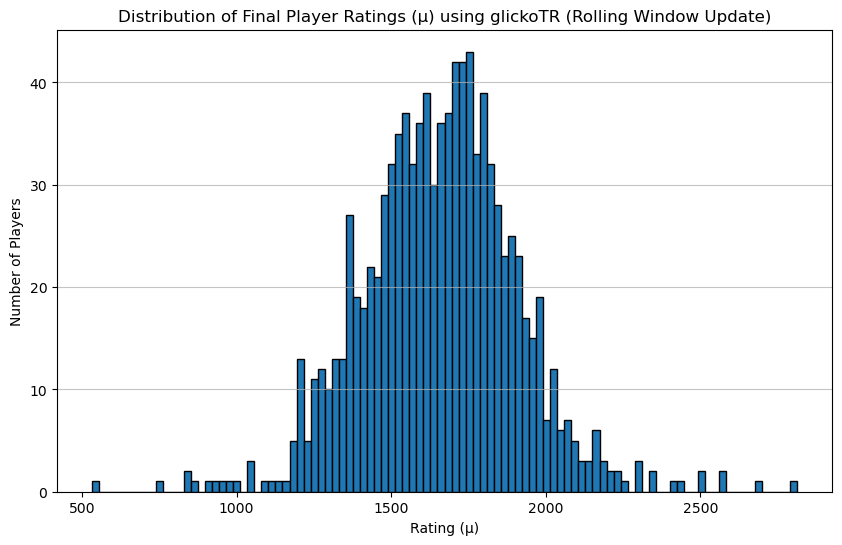

In [55]:
# --- Plotting uses 'final_players' dictionary now ---

if final_players: # Check if final player data exists
    final_mus = [p.mu for p in final_players.values() if hasattr(p, 'mu')]

    if final_mus:
        plt.figure(figsize=(10, 6))
        plt.hist(final_mus, bins=100, edgecolor='black')
        plt.title('Distribution of Final Player Ratings (μ) using glickoTR (Rolling Window Update)')
        plt.xlabel('Rating (μ)')
        plt.ylabel('Number of Players')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No final ratings data with 'mu' attribute found to plot.")
else:
    print("Skipping distribution plot as final player data is missing.")

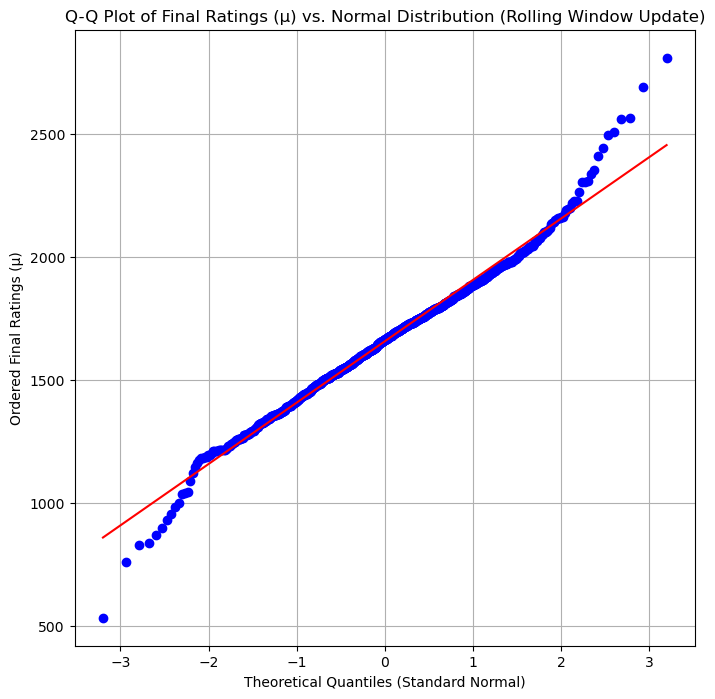

In [54]:
import scipy.stats as stats

# --- Plotting uses 'final_players' dictionary now ---

if final_players and 'final_mus' in locals() and final_mus: # Check if final player data and mus exist
    plt.figure(figsize=(8, 8))
    # Create the Q-Q plot against a normal distribution
    stats.probplot(final_mus, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Final Ratings (μ) vs. Normal Distribution (Rolling Window Update)')
    plt.xlabel('Theoretical Quantiles (Standard Normal)')
    plt.ylabel('Ordered Final Ratings (μ)')
    plt.grid(True)
    plt.show()
else:
    print("Skipping Q-Q plot as final ratings data is missing or empty.")